In [1]:
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

while not os.path.isfile("README.md"):
    %cd ..

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_sample_weight
import shap
import lightgbm as lgb
from lib.preprocess import get_data, Preprocess

pd.set_option('display.max_colwidth', None)
BASE_PATH = os.path.abspath("")
FILE_NAME = "lgbm_main"

/home/nakagawa/fdua_finance_competition


In [2]:
X_train, y_train, X_test = get_data()

In [3]:
def mean_f1score(preds:np.ndarray,eval_data: lgb.Dataset):
    y_true = eval_data.get_label()
    weight = eval_data.get_weight()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    f1 = f1_score(y_true,preds,average='macro',sample_weight=weight)
    return 'f1',f1,True

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'objective': 'multiclass',
    'metric': None,
    'num_class': 2,
    'seed': 42,
    "boosting_type": "gbdt",
}

In [5]:
best_score = 0 
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # split
    print(f"Fold {fold + 1}")
    X_trn = X_train.iloc[trn_idx].copy()
    y_trn = y_train.iloc[trn_idx].copy()
    X_val = X_train.iloc[val_idx].copy()
    y_val = y_train.iloc[val_idx].copy()

    # preprocess
    ppr = Preprocess()
    X_trn = ppr.fit_transform(X_trn, y_trn)
    X_val = ppr.transform(X_val)

    # train
    train_set = lgb.Dataset(X_trn, y_trn)# ,weight=compute_sample_weight(class_weight='balanced',y=y_trn))
    val_set = lgb.Dataset(X_val, y_val, reference=train_set)
    model = lgb.train(
        params,
        train_set,
        num_boost_round=10000,
        valid_sets=[val_set],
        valid_names=["val"],
        feval=mean_f1score,
        callbacks=[
            # lgb.early_stopping(500,)
        ],
    )

    # inference
    preds = model.predict(X_val)
    preds = preds.reshape(len(np.unique(y_val)), -1)
    preds = preds.argmax(axis = 0)
    print("0, 1: ",sum(preds==0), sum(preds==1))
    score = f1_score(y_val, preds, average='macro')
    if score > best_score:
        best_score = score
        best_xval = X_val
        best_yval = y_val
        best_ppr = ppr
        best_model = model
    print(f"Score: {score}")
    print("-" * 100)

Fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 23
[LightGBM] [Info] Start training from score -2.232008
[LightGBM] [Info] Start training from score -0.113519
[1]	val's multi_logloss: 0.325678	val's f1: 0.471653
[2]	val's multi_logloss: 0.316788	val's f1: 0.471653
[3]	val's multi_logloss: 0.31027	val's f1: 0.471653
[4]	val's multi_logloss: 0.305085	val's f1: 0.471653
[5]	val's multi_logloss: 0.301451	val's f1: 0.471653
[6]	val's multi_logloss: 0.298558	val's f1: 0.471653
[7]	val's multi_logloss: 0.29558	val's f1: 0.471653
[8]	val's multi_logloss: 0.293356	val's f1: 0.471653
[9]	val's multi_logloss: 0.2916	val's f1: 0.50797
[10]	val's multi_logloss: 0.289878	val's f1: 0.539543
[11

In [6]:
# calibration
print(f"Best CV score before calibration: {best_score}")
zero_ratio = sum(best_yval==0) / len(best_yval)
n_zero = int(zero_ratio * len(best_yval))
y_prob = best_model.predict(best_xval)
y_prob = y_prob.reshape(len(np.unique(best_yval)), -1)
y_prob = pd.DataFrame(y_prob.T, columns=["0", "1"], index=best_xval.index)
y_pred = pd.DataFrame([1]*len(best_xval), columns=["pred"], index=best_xval.index)
y_pred.loc[y_prob.sort_values("0").index[:n_zero]] = 0
score = f1_score(best_yval, y_pred, average='macro')
print(f"Best CV score after calibration: {score}")

Best CV score before calibration: 0.41429678048564067
Best CV score after calibration: 0.49540880275713883


In [7]:
# submission
n_zero = int(zero_ratio * len(X_test))
X_test = best_ppr.transform(X_test)
probs = best_model.predict(X_test)
probs = probs.reshape(len(np.unique(y_train)), -1)
probs = pd.DataFrame(probs.T, columns=["0", "1"], index=X_test.index)
preds = pd.DataFrame([1]*len(X_test), columns=["pred"], index=X_test.index)
preds.loc[probs.sort_values("0").index[:n_zero]] = 0

In [8]:
result_dir = f"results/{FILE_NAME}"
if os.path.exists(result_dir):
    idx = 1
    result_dir += f"_v{idx}"
    while os.path.exists(result_dir):
        idx += 1
        result_dir = result_dir.split('_v')[0]
        result_dir += f"_v{idx}"
        
os.makedirs(result_dir, exist_ok=False)
shutil.copytree("lib", os.path.join(result_dir, "lib"))
shutil.copyfile(f"notebooks/{FILE_NAME}.ipynb", os.path.join(result_dir, f"{FILE_NAME}.ipynb"))
preds.to_csv(os.path.join(result_dir, f"submission.csv"), index=True, header=False)

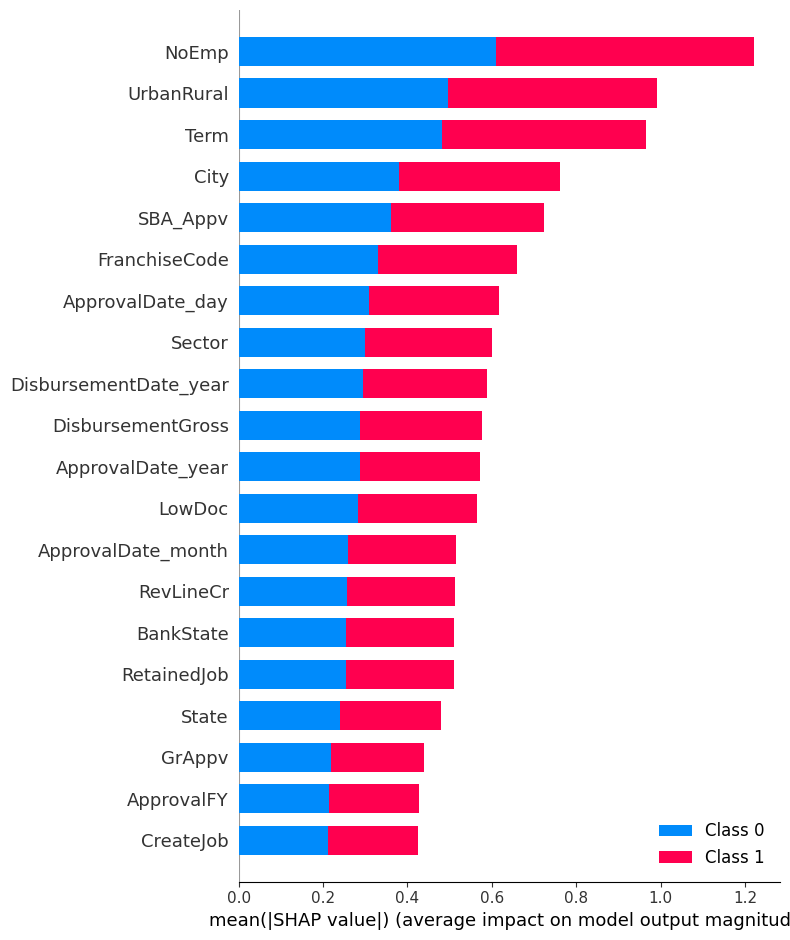

In [9]:
shap_values = shap.TreeExplainer(best_model).shap_values(best_xval)
shap.summary_plot(shap_values, best_xval, plot_type="bar", show=True)

In [10]:
%pip install plyer
from plyer import notification

notification.notify(
    title="From Python",
    message="Executed Successfully",
    app_name='Python',
    app_icon=os.path.join(BASE_PATH,'lib/notification.ico'),
)

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
